# 0. Download the dataset from Kaggle to Colab

Instead of using the original dataset, which is too large to download for my PC, I downloaded the resized data created by Steven Li 198802: \
https://www.kaggle.com/datasets/stevenli198802/histopathologic-cancer-detection-resized

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder"

In [ ]:
# %cd /content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder

/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder


In [ ]:
#!kaggle datasets download -d stevenli198802/histopathologic-cancer-detection-resized

Dataset URL: https://www.kaggle.com/datasets/stevenli198802/histopathologic-cancer-detection-resized
License(s): other
 99% 1.38G/1.38G [00:22<00:00, 47.3MB/s]
100% 1.38G/1.38G [00:22<00:00, 67.1MB/s]


Note that the code below takes a while even with the resized dataset.

In [ ]:
#!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: converted_test/converted_test/fdcab2e94c12679fd3efdd243d082891b909a1ac.png  
  inflating: converted_test/converted_test/fdcb0903020c0630fd7fef6548939778a520b553.png  
  inflating: converted_test/converted_test/fdcb9e36d61f5e044b170e413d2097d86cbcd325.png  
  inflating: converted_test/converted_test/fdcc357640b38324f62df700078a87b66af846ed.png  
  inflating: converted_test/converted_test/fdcc97020d3e40eb29a46160bf11fe25601348e9.png  
  inflating: converted_test/converted_test/fdcc97708ff317e4a9e49f949b1defe2cfe2b90e.png  
  inflating: converted_test/converted_test/fdcd1a9ab4007024386f887776281bc977cbb001.png  
  inflating: converted_test/converted_test/fdcf42c4b744e9d61ba9209c3a0dbebb572bcdb2.png  
  inflating: converted_test/converted_test/fdd2e44d0e55f9a08abee5639f76d1dbd17a8401.png  
  inflating: converted_test/converted_test/fdd343fbbbb0157708d641517ca40f49226775e2.png  
  inflating: converted_test/converted_test/fdd4f0

# 1 Load the Libraries and Dataset




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the necessary libraries for data manipulation, visualization, and model building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from numpy.random import seed
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
# Download Dataset

# Load train labels from CSV file
train_labels = pd.read_csv('/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/train_labels.csv')
print(train_labels.shape)
print(train_labels.head())
print('-----')
# Count the number of 0s and 1s in the label column
label_counts = train_labels['label'].value_counts()
print(label_counts)


(220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
-----
label
0    130908
1     89117
Name: count, dtype: int64


In [ ]:
# Set the paths to the train and test datasets
train_0_dir = '/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_train/0'
train_1_dir = '/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_train/1'
test_dir = '/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_test'

# Count the number of files in the folder
num_files0 = len([f for f in os.listdir(train_0_dir) if os.path.isfile(os.path.join(train_0_dir, f))])
num_files1 = len([f for f in os.listdir(train_1_dir) if os.path.isfile(os.path.join(train_1_dir, f))])
print(f"Number of train images with the label 0: {num_files0}")
print(f"Number of train images with the label 1: {num_files1}")

Number of train images with the label 0: 2252
Number of train images with the label 1: 2253


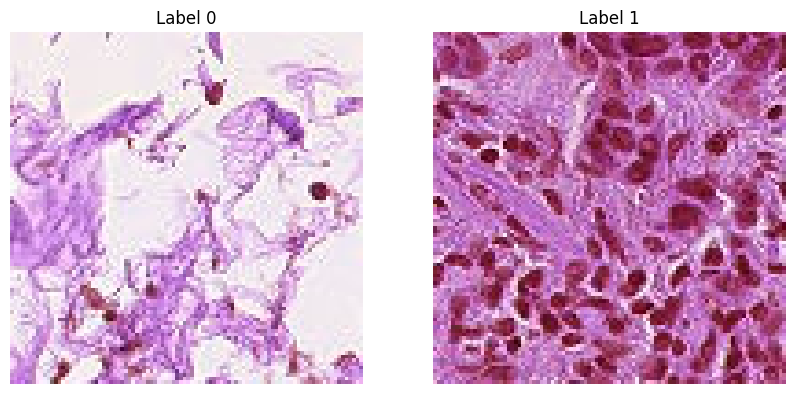

In [ ]:
# Sample images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1) # label == 0
img0 = cv2.imread('/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_train/0/0000d563d5cfafc4e68acb7c9829258a298d9b6a.png')
plt.imshow(img0)
plt.title("Label 0")
plt.axis('off')

plt.subplot(1, 2, 2) # label == 1
img1 = cv2.imread('/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_train/1/0000da768d06b879e5754c43e2298ce48726f722.png')
plt.imshow(img1)
plt.title("Label 1")
plt.axis('off')
plt.show()

# 2. EDA for the Dataset

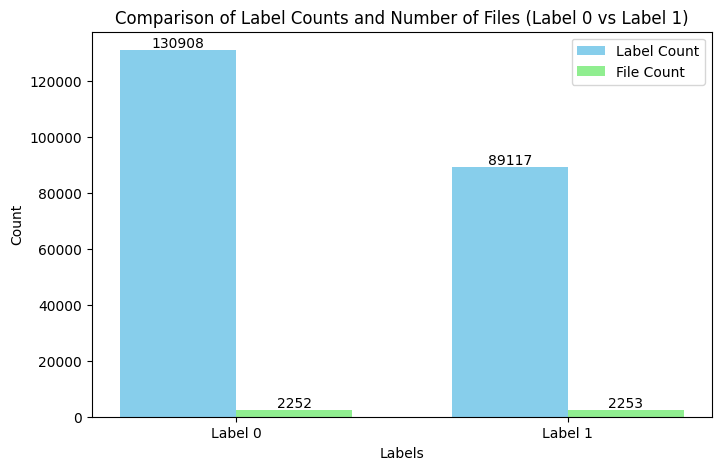

In [ ]:
# Define the labels and corresponding counts
labels = ['Label 0', 'Label 1']
label_data = [label_counts[0], label_counts[1]]  # Count of 0s and 1s in label column
file_data = [num_files0, num_files1]  # Number of files for 0 and 1 labels

# Create a bar chart with 2 bars for each label (one for label count, one for file count)
x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

plt.figure(figsize=(8, 5))

# Plotting the bars
bar1 = plt.bar(x - width/2, label_data, width, label='Label Count', color='skyblue')
bar2 = plt.bar(x + width/2, file_data, width, label='File Count', color='lightgreen')

# Set labels, title, and legend
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Comparison of Label Counts and Number of Files (Label 0 vs Label 1)')
plt.xticks(x, labels)
plt.legend()

# Display the count values on top of each bar
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Show the plot
plt.show()

Compared to the original dataset, the resized one is rather small (almost 2%). The ratio of the labels is balanced.

# 3. Model

## 3.1 Preprocess data

In [ ]:
# Function to check if the image exists in the appropriate directory
def image_exists(row):
    img_id = row['id']
    label = row['label']

    # Determine the directory based on the label
    if label == 0:
        img_path = os.path.join(train_0_dir, img_id + '.png')
    else:
        img_path = os.path.join(train_1_dir, img_id + '.png')

    # Return True if the image exists, False otherwise
    return os.path.exists(img_path)

# Filter the rows in train_labels where the image exists
train_labels_filtered = train_labels[train_labels.apply(image_exists, axis=1)]

# Check the shape of the filtered dataframe
print(f"Original number of rows: {train_labels.shape[0]}")
print(f"Filtered number of rows: {train_labels_filtered.shape[0]}")

Original number of rows: 220025
Filtered number of rows: 4505


## 3.2 Split data

In [ ]:
train_labels_filtered.head()

,id,label
64,0c9048efaa80ab8813fde3b649cfc54f02dabe56,1
67,0b474bcdd1b201e76914dac7abd35794761643d0,0
77,109c481433e8c78e60f1e7a859c0b4da5cec1455,0
105,082b8707b3dd05e45323099819e61bd2cccc1b1d,1
127,14e1234a200b8ea02e86ea9630d8219aaa574d19,0


In [ ]:
random.seed(42)
df0 = train_labels_filtered[train_labels_filtered['label']==0].sample(500)
df1 = train_labels_filtered[train_labels_filtered['label']==1].sample(500)
df_data = pd.concat([df0, df1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)

print(df_data['label'].value_counts())

label
0    500
1    500
Name: count, dtype: int64


In [ ]:
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.20, stratify=y)

print(df_train.shape)
print(df_val.shape)

(800, 2)
(200, 2)


## 3.3 Construct Model
I refer to the model structure of this notebook
https://www.kaggle.com/code/shaunyoon/cancer-detection

In [ ]:
# change the current directry
%cd /content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/model_folder
# # Get the current working directory
# current_directory = os.getcwd()
# print(f"Current working directory: {current_directory}")

/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/model_folder


In [ ]:
# # create model folders
# os.mkdir('base')
# os.mkdir('base/train')
# os.mkdir('base/val')
# os.mkdir('base/train/0')
# os.mkdir('base/train/1')
# os.mkdir('base/val/0')
# os.mkdir('base/val/1')

/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/model_folder


In [ ]:
# # Allocate the images to the folders
# for image in list(df_train[df_train['label']==0]['id']):
#     shutil.copyfile('/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_train/0/'+image+'.png', 'base/train/0/'+image+'.png')

# for image in list(df_train[df_train['label']==1]['id']):
#     shutil.copyfile('/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_train/1/'+image+'.png', 'base/train/1/'+image+'.png')

# for image in list(df_val[df_val['label']==0]['id']):
#     shutil.copyfile('/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_train/0/'+image+'.png', 'base/val/0/'+image+'.png')

# for image in list(df_val[df_val['label']==1]['id']):
#     shutil.copyfile('/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_train/1/'+image+'.png', 'base/val/1/'+image+'.png')


In [ ]:
print(len(os.listdir('base/train/0')))
print(len(os.listdir('base/train/1')))
print(len(os.listdir('base/val/0')))
print(len(os.listdir('base/val/1')))

400
400
100
100


In [ ]:
# Set up the generators
train_path = 'base/train'
valid_path = 'base/val'
test_path = '/content/drive/MyDrive/Edu/Kaggle/CNN_histopathologic-cancer-detection/data_folder/converted_test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = int(np.ceil(num_train_samples // train_batch_size))
val_steps = int(np.ceil(num_val_samples // val_batch_size))

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(96,96),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(96,96),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(96,96),
                                        batch_size=1,
                                        classes=['test'],
                                        shuffle=False)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 57437 images belonging to 1 classes.


In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 64
second_filters = 128
third_filters = 256
fourth_filters = 512

dropout_conv = 0.5
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu',padding='same', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu',padding='same'))
model.add(MaxPooling2D(pool_size = pool_size))

model.add(Conv2D(second_filters, kernel_size, activation ='relu',padding='same'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu',padding='same'))
model.add(MaxPooling2D(pool_size = pool_size))

model.add(Conv2D(third_filters, kernel_size, activation ='relu',padding='same'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu',padding='same'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu',padding='same'))
model.add(MaxPooling2D(pool_size = pool_size))

model.add(Conv2D(fourth_filters, kernel_size, activation ='relu',padding='same'))
model.add(Conv2D(fourth_filters, kernel_size, activation ='relu',padding='same'))
model.add(Conv2D(fourth_filters, kernel_size, activation ='relu',padding='same'))

model.add(Flatten())
model.add(Dense(4096, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(4096, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     301,993,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           8,194 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 326,418,754 (1.22 GB)

 Trainable params: 326,418,754 (1.22 GB)

 Non-trainable params: 0 (0.00 B)

The points below are part of the techniques used to improve CNNs and are reflected in this model:
- Applying Max-pooling
- Using small filters and a deep structure rather than wide filters and a shallow structure
- Applying dropout, etc.

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=['AUC'])

In [ ]:
print(val_gen.class_indices)

{'0': 0, '1': 1}


In [ ]:
filepath = "model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 813s 9s/step - AUC: 0.5225 - loss: 0.6942 - val_AUC: 0.7376 - val_loss: 0.6891 - learning_rate: 1.0000e-04
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - AUC: 0.6348 - loss: 0.6892 - val_AUC: 0.7915 - val_loss: 0.6142 - learning_rate: 1.0000e-04
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - AUC: 0.6346 - loss: 0.6741 - val_AUC: 0.8743 - val_loss: 0.5851 - learning_rate: 1.0000e-04
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - AUC: 0.7482 - loss: 0.6096 - val_AUC: 0.8910 - val_loss: 0.4138 - learning_rate: 1.0000e-04
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - AUC: 0.7719 - loss: 0.5681 - val_AUC: 0.8989 - val_loss: 0.4332 - learning_rate: 1.0000e-04
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - AUC: 0.8377 - loss: 0.4977 - val_AUC: 0.7921 - val_loss: 0.5500 - learning_rate: 1.0000e-04
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - AUC: 0.7696 - loss: 0.5741 - val_AUC: 0.8643 - val_loss: 0.4591 - learning_rate: 1.0000e-04
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - AUC: 0.8378 - loss: 0.4986 - val_AUC: 0.9079 - val_loss: 0.3948 - learning_ra

Only the first epoch took time (around 15 min). The rest part was finished soon.

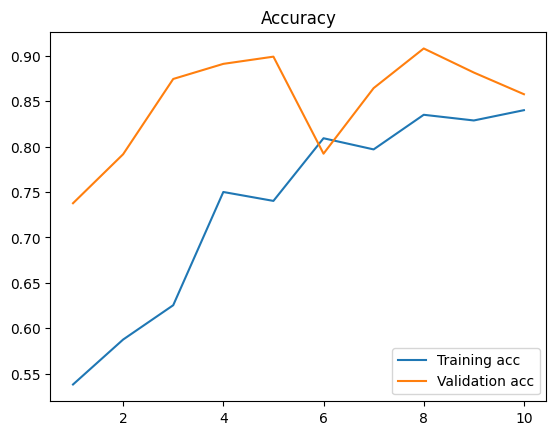

In [ ]:
tr_acc = history.history['AUC']
val_acc = history.history['val_AUC']

epoc = range(1, len(tr_acc) + 1)

plt.plot(epoc, tr_acc, label='Training acc')
plt.plot(epoc, val_acc, label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.show()

(Conclusion) \
At the 1oth epoch, the validation acc reached around 0.85. \
Considering that this is a medical problem, this rate will not be considered accurate enough. However, in a domain where errors are not as fatal as medicine, it is remarkable that the performance of mechanical algorithm was improved over 85% with limited input.

In [ ]:
predictions = model.predict(test_gen, verbose=1)

NameError: name 'model' is not defined

I ran the prediction code below for more than 4 hours with T4 GPU on Google Colab, but the run time was disconnected and failed to create prediction labels based on the model. Thus, the score is not as good as the validation acc.\
The rest of the codes are the ones to convert the predicted value 0 or 1 and make a csv file to submit.

In [ ]:
predictions

In [ ]:
df_preds = pd.DataFrame(predictions, columns=['0', '1'])

df_preds.head()

In [ ]:
df_preds[df_preds['1']>0.5]

In [ ]:
df_preds['file_names'] = test_gen.filenames

In [ ]:
df_preds['id'] = df_preds['file_names'].str[5:-4]
df_preds[['id','1']].rename(columns={'1':'label'}).to_csv('submission.csv', columns=['id','label'],index=False)

In [ ]:
pd.read_csv('submission.csv')